In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns;sns.set()
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [108]:
Price = pd.read_csv('PriceStats_CPI.csv', parse_dates=[0])
Price = Price.set_index('date')
Price.head()
BER = pd.Series.from_csv('T10YIE.csv')
BER.head()

DATE          T10YIE
2003-01-02      1.64
2003-01-03      1.62
2003-01-06      1.63
2003-01-07      1.62
dtype: object

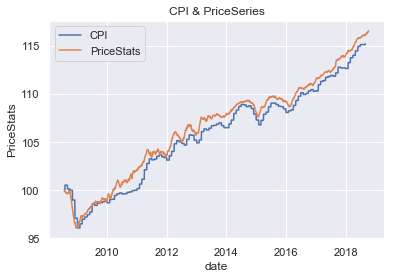

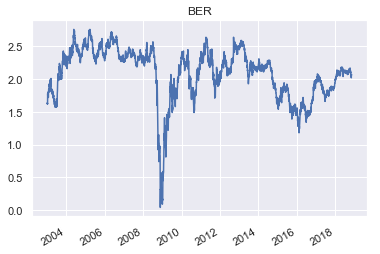

In [4]:
plt.figure()
_ = sns.lineplot(Price.index,'CPI',data = Price, label = "CPI")
_ = sns.lineplot(Price.index,'PriceStats',data = Price, label = "PriceStats")
_ = plt.title('CPI & PriceSeries')
plt.show()
plt.figure()
BER = pd.to_numeric(BER, errors = 'coerce')
BER = BER.dropna()
BER.index = pd.to_datetime(BER.index)
BER.plot()
plt.title('BER')
plt.show()

In [5]:
CPI = Price['CPI']
CPI.columns = ['CPI']
PriceStats = Price['PriceStats']

### (a) AR model to CPI

In [6]:
CPI_month = CPI.resample(rule = 'MS').first()
CPI_month = CPI_month.dropna()
CPI_month_diff = CPI_month.diff()
# plt.figure()
# ax = plot_pacf(CPI_month, lags = 20)
# plt.show()
CPI_month_diff.autocorr()
display(CPI_month.head())

date
2008-07-01    100.00000
2008-08-01    100.52510
2008-09-01    100.12380
2008-10-01     99.98538
2008-11-01     98.97539
Freq: MS, Name: CPI, dtype: float64

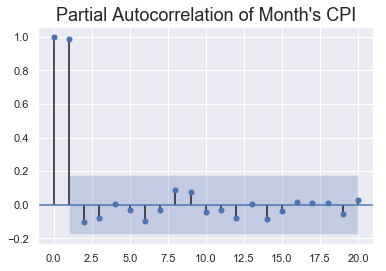

In [7]:
plot_pacf(CPI_month, lags=20)
plt.title('Partial Autocorrelation of Month\'s CPI', fontsize = 18)
plt.show()

In [107]:
model_ar1 = ARMA(CPI_month, order = (1,0))
result = model_ar1.fit()
print(result.summary())

                              ARMA Model Results                              
Dep. Variable:                    CPI   No. Observations:                  123
Model:                     ARMA(1, 0)   Log Likelihood                 -67.505
Method:                       css-mle   S.D. of innovations              0.409
Date:                Tue, 27 Nov 2018   AIC                            141.010
Time:                        18:15:33   BIC                            149.447
Sample:                    07-01-2008   HQIC                           144.437
                         - 09-01-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        107.4531      6.965     15.427      0.000      93.802     121.105
ar.L1.CPI      0.9984      0.002    467.374      0.000       0.994       1.003
                                    Roots           

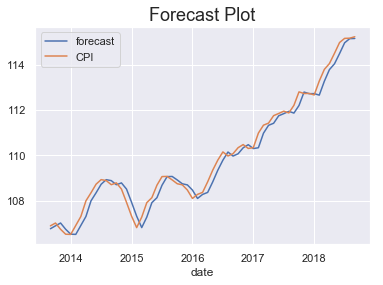

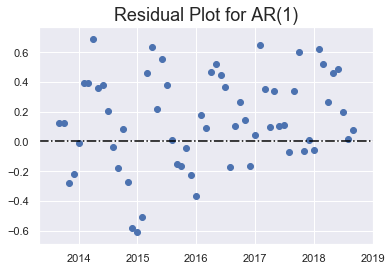

mean square error is:0.1169985378054629


In [9]:
result.plot_predict(start = '2013-09-01')
plt.title('Forecast Plot', fontsize=18)
plt.show()
prediction = result.predict()['2013-09-01':]
residual = CPI_month['2013-09-01':]-prediction
plt.scatter(residual.index,residual)
plt.axhline(y=0, color='black', linestyle='-.')
plt.title('Residual Plot for AR(1)', fontsize=18)
plt.show()
print("mean square error is:"+str(np.mean(residual**2) ) )

## (b) Inflation Rate

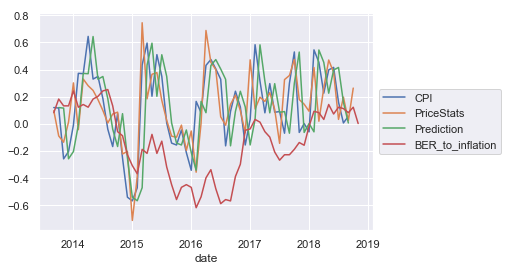

In [10]:
#get CPI inflation rate 
CPI_inflation = CPI_month.pct_change()['2013-09-01':]*100
#get PriceStats inflation rate
PriceStats_month = PriceStats.resample(rule = 'MS').first()
PriceStats_inflation  = PriceStats_month.pct_change()['2013-09-01':]*100
#Get BER inflation rate
BER_month = BER.resample(rule = 'MS').first()
BER_month_onwards = BER_month['2013-09-01':]

# BER_month_onwards_percentage = BER_month_onwards/100
#Get predtion inflation rate
prediction_inflation = prediction.pct_change()*100
#######
#determine the fixed rate
fix_rate = BER_month_onwards.mean()+CPI_inflation.mean()
BER_month_onwards_inflation = BER_month_onwards-fix_rate
#########
#Plot
CPI_inflation.plot(label='CPI')
PriceStats_inflation.plot(label='PriceStats')
prediction_inflation.plot(label='Prediction')
BER_month_onwards_inflation.plot(label='BER_to_inflation')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## (c) External Regression

### End of month

In [90]:
CPI_end_month = CPI.resample(rule="M").first()
CPI_month_lag_1 = CPI_end_month.shift(1)[1:-1]
########
CPI_month_lag_1_frame = pd.DataFrame(CPI_month_lag_1)
####
PriceStats_end_month = PriceStats.resample(rule="M").first()
PriceStats_month_frame = pd.DataFrame(PriceStats_end_month)
BER_end_month = BER.resample(rule='M').first()
BER_frame = pd.DataFrame(BER_end_month)
X = CPI_month_lag_1_frame.join(PriceStats_month_frame, how = 'inner')
X = X.join(BER_frame, how = 'inner')
X.columns = ["CPI", "PriceStats", "BER"]
X = sm.add_constant(X)
Y = CPI_end_month[1:-1]

In [91]:
model = sm.OLS(Y,X)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    CPI   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 1.568e+04
Date:                Tue, 27 Nov 2018   Prob (F-statistic):          2.72e-153
Time:                        17:24:12   Log-Likelihood:                -4.2027
No. Observations:                 122   AIC:                             16.41
Df Residuals:                     118   BIC:                             27.62
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4148      0.513      0.809      0.4

In [92]:
print("mean square error is {}".format(mean_squared_error(Y, res.predict(X)) ) )

mean square error is 0.0627259625455


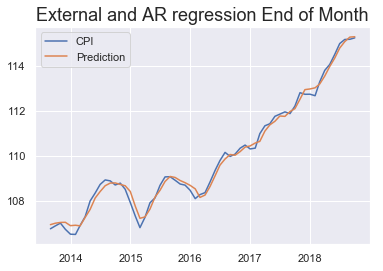

In [93]:
plt.plot(Y['2013-08-31':], label = "CPI")
plt.plot(res.predict(X)['2013-08-31':], label= "Prediction")
plt.title("External and AR regression End of Month", fontsize = 18)
plt.legend()
plt.show()

### Mean of month

In [103]:
CPI_mean_month = CPI.resample(rule="M").mean()
CPI_month_lag_1 = CPI_mean_month.shift(1)[1:-1]
########
CPI_month_lag_1_frame = pd.DataFrame(CPI_month_lag_1)
####
PriceStats_end_month = PriceStats.resample(rule="M").mean()
PriceStats_month_frame = pd.DataFrame(PriceStats_end_month)
BER_end_month = BER.resample(rule='M').mean()
BER_frame = pd.DataFrame(BER_end_month)
X = CPI_month_lag_1_frame.join(PriceStats_month_frame, how = 'inner')
X = X.join(BER_frame, how = 'inner')
X.columns = ["CPI", "PriceStats", "BER"]
X_mean = sm.add_constant(X)
Y_mean = CPI_mean_month[1:-1]

In [104]:
model = sm.OLS(Y_mean,X_mean)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    CPI   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 1.486e+04
Date:                Tue, 27 Nov 2018   Prob (F-statistic):          6.40e-152
Time:                        17:27:26   Log-Likelihood:                -7.4659
No. Observations:                 122   AIC:                             22.93
Df Residuals:                     118   BIC:                             34.15
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1177      0.527      0.223      0.8

In [105]:
print("mean square error is {}".format(mean_squared_error(Y_mean, res.predict(X_mean)) ) )

mean square error is 0.066172798511


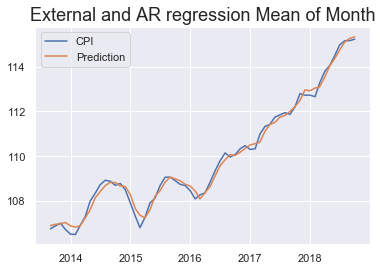

In [106]:
plt.plot(Y_mean['2013-08-31':], label = "CPI")
plt.plot(res.predict(X_mean)['2013-08-31':], label= "Prediction")
plt.title("External and AR regression Mean of Month", fontsize = 18)
plt.legend()
plt.show()

## (d) More accuracy with MA or seasonal

In [47]:
X_Frame = BER_frame.join(PriceStats_month_frame)
model_ar1_external = SARIMAX(CPI_month, order = (1,0,0), exog=PriceStats_month[:-1] ,seasonal_order=(1,1,1,12))
result_external = model_ar1_external.fit()
print(result.summary())

                              ARMA Model Results                              
Dep. Variable:                    CPI   No. Observations:                  123
Model:                     ARMA(1, 0)   Log Likelihood                 -67.505
Method:                       css-mle   S.D. of innovations              0.409
Date:                Tue, 27 Nov 2018   AIC                            141.010
Time:                        16:53:19   BIC                            149.447
Sample:                    07-01-2008   HQIC                           144.437
                         - 09-01-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        107.4531      6.965     15.427      0.000      93.802     121.105
ar.L1.CPI      0.9984      0.002    467.374      0.000       0.994       1.003
                                    Roots           

In [48]:
mean_squared_error(CPI_month['2013-09-01':], result_external.predict()['2013-09-01':] )

0.032383332601187635

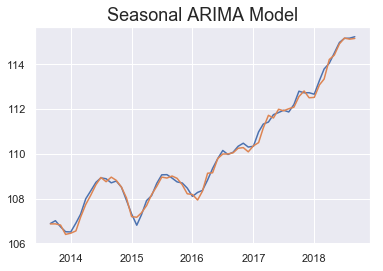

In [71]:
plt.plot(CPI_month['2013-09-01':], label = "Original")
plt.plot(result_external.predict()['2013-09-01':], label = "Seasonal ARIMA")
plt.title('Seasonal ARIMA Model', fontsize=18)
plt.show()